In [1]:
import os
import re
import gc

import numpy as np
import pandas as pd
import xarray as xr

import cftime
import pop_tools  
import gsw

# debugging of `smoc_all_timeseries.py`

In [2]:
# choose latitude
sel_nlat = 345

vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel'
temp_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp'
salt_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt'

output_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries'

# this is not the most elegant way, it would be better to just give the nlon range
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [45.0, 66.0], 'TLONG': [260.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}
    ]
}
maskSPG = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='Subpolar Gyre')
maskSPG = maskSPG.sum('region')
maskSPG = maskSPG.roll(nlon=-100)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
def extract_member_id(filename):
    match = re.search(r'vvel_([^.]+(?:\.\d+)?)\.nc', filename)
    return match.group(1) if match else None

def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def calculate_sigma2(temp_ds, salt_ds, nlat):
    CT = gsw.conversions.CT_from_pt(salt_ds['SALT'].isel(nlat=nlat), temp_ds['TEMP'].isel(nlat=nlat))
    sigma2_at_latitude = gsw.density.sigma2(salt_ds['SALT'].isel(nlat=nlat), CT)
    sigma2_at_latitude = sigma2_at_latitude.rename('SIGMA_2')
    return sigma2_at_latitude

def load_and_process_dataset(file_path, mask):
    ds = xr.open_dataset(file_path, decode_times=False).isel(time=slice(0,10))
    ds = standardise_time(ds)
    try:
        processed_dataset = ds.roll(nlon=-100).where(mask)
    except (RuntimeError, IndexError) as e:
        print(f"Initial processing failed, loading step-by-step: {str(e)}")
        processed_dataset = handle_deprecated_data(ds, mask)
    return processed_dataset

def handle_deprecated_data(ds, mask):
    total_time_steps = ds.dims['time']
    last_valid_data = None
    for t in range(total_time_steps):
        try:
            current_data = ds.isel(time=t).load()
            last_valid_data = current_data
        except RuntimeError as e:
            print(f"Error at timestep {t}: {str(e)}")
            if last_valid_data is not None:
                current_data = last_valid_data
            else:
                raise ValueError(f"No valid data at timestep {t}")
        if t == 0:
            combined_data = current_data
        else:
            combined_data = xr.concat([combined_data, current_data], dim='time')
    combined_data['time'] = np.arange(total_time_steps)
    result_dataset = combined_data.roll(nlon=-100).where(mask)
    return result_dataset

def density_overturning(vvel_dataset, density_dataset, latitude_index):
    density_bins = [12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 
                   31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4, 33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 
                   35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 36.4, 36.42, 
                   36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 
                   36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 36.78, 36.8, 36.82, 
                   36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 37.14, 
                   37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
    max_overturning_series = []

    cell_thickness = vvel_dataset['dz'].isel(nlat=latitude_index)
    cell_width = vvel_dataset['DXU'].isel(nlat=latitude_index)
    
    for time_step in range(len(vvel_dataset.time)):
        try:
            # compute meridional flow rate for the specified latitude
            velocity = vvel_dataset['VVEL'].isel(time=time_step, nlat=latitude_index)
            flow_rate = velocity * cell_thickness * cell_width

            # compute meridional flow rate and for each density bin and integrate zonally
            density_at_time = density_dataset.isel(time=time_step)
            flow_rate_by_density = np.zeros(len(density_bins))
            for bin_index in range(len(density_bins) - 1):
                in_bin = (density_at_time >= density_bins[bin_index]) & (density_at_time < density_bins[bin_index + 1])
                flow_rate_by_density[bin_index] = flow_rate.where(in_bin).sum()

            # compute density overturning, reverse to integrate from high to low density
            density_overturning = np.cumsum(flow_rate_by_density)[::-1]
            max_overturning = np.max(density_overturning)
            max_overturning_series.append(max_overturning)
        except IndexError as e:
            print(f"Error occurred at time step: {time_step}")
            raise e
    
    max_overturning_dataarray = xr.DataArray(max_overturning_series, dims=["time"], coords={"time": vvel_dataset['time']})
    return max_overturning_dataarray  * 1e-12

1001.001 saved
1231.001 saved


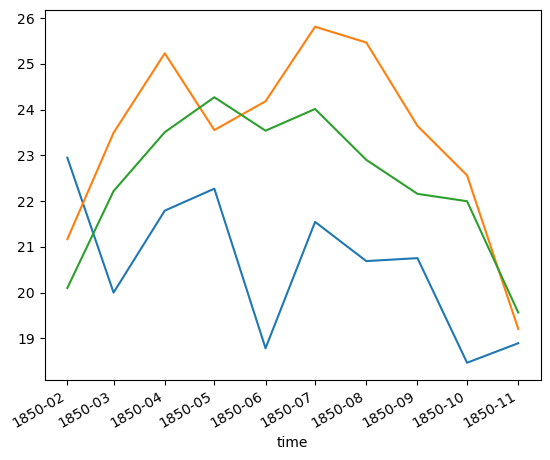

In [9]:
total_members = len(os.listdir(temp_dir))
processed_count = 0

counter=0

for file in os.listdir(vvel_dir):
    member_id = extract_member_id(file)
    vvel_path = os.path.join(vvel_dir, file)
    temp_path = os.path.join(temp_dir, f'temp_{member_id}.nc')
    salt_path = os.path.join(salt_dir, f'salt_{member_id}.nc')
 
    temp_ds = load_and_process_dataset(temp_path, maskSPG)
    salt_ds = load_and_process_dataset(salt_path, maskSPG)
    sigma_ds = calculate_sigma2(temp_ds, salt_ds, sel_nlat)
    vvel_ds = load_and_process_dataset(vvel_path, maskSPG)
    
    max_overturning_series = density_overturning(vvel_ds, sigma_ds, sel_nlat)
    #max_overturning_series.to_netcdf(os.path.join(output_dir, f'monthly_smoc55_member_{member_id}.nc'))
    
    max_overturning_series.plot()
    
    temp_ds.close()
    salt_ds.close()
    sigma_ds.close()
    vvel_ds.close()
    max_overturning_series.close()

    del temp_ds, salt_ds, sigma_ds, vvel_ds, max_overturning_series
    gc.collect()
    
    counter += 1
    if counter >= 3:
        break
    
    